In [11]:
import fiona
import collections
import matplotlib.pyplot as plt
import pyproj
import rasterio
import rasterio.mask
from rasterio.plot import show
from rasterio import features
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
from datetime import date
import geopandas
import os
from shapely import geometry
import numpy as np
import warnings
warnings.filterwarnings('ignore')

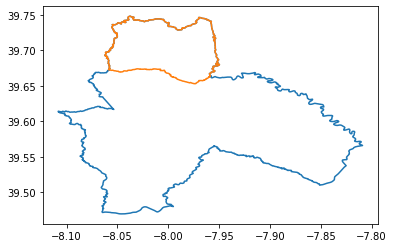

In [2]:
freguesias_shapes=fiona.open("gadm36_PRT_shp/gadm36_PRT_3.shp")
concelhos_shapes = fiona.open("gadm36_PRT_shp/gadm36_PRT_2.shp")


for shp in freguesias_shapes:
    #print(shp['properties']['NAME_3'])
    if shp['properties']['NAME_3']=='Cardigos' :
        cardigos_shp = shp

for shp in concelhos_shapes:
    if shp['properties']['NAME_2'] =='Mação':
        macao_shp = shp

cardigos_x = [point[0] for point in cardigos_shp['geometry']['coordinates'][0]]
cardigos_y = [point[1] for point in cardigos_shp['geometry']['coordinates'][0]]
macao_x = [point[0] for point in macao_shp['geometry']['coordinates'][0]]
macao_y = [point[1] for point in macao_shp['geometry']['coordinates'][0]]

plt.figure()
plt.plot(macao_x,macao_y)
plt.plot(cardigos_x,cardigos_y)
plt.show()

***

In [12]:
#image_dir = 'S2B_MSIL2A_20210320T112109_N0214_R037_T29TNE_20210320T130843.SAFE/GRANULE/L2A_T29TNE_A021084_20210320T112112/IMG_DATA/R10m/'
image_dir = 'S2B_MSIL1C_20210320T112109_N0209_R037_T29TNE_20210320T123052.SAFE/GRANULE/L1C_T29TNE_A021084_20210320T112112/IMG_DATA'

In [13]:
def transform_shapefile(shp):
    transformer = pyproj.Transformer.from_crs("epsg:4326", "epsg:32629")
    p1 = pyproj.Proj('epsg:4326', preserve_units=False)
    p2 = pyproj.Proj('epsg:32629', preserve_units=False)
    shp_t={
        'type':shp['type'],
        'id':shp['id'],
        'properties':shp['properties'],
        'geometry':{'type':shp['geometry']['type'],
                    'coordinates':[pt for pt in pyproj.itransform(p1,p2,shp['geometry']['coordinates'][0], always_xy=True)]}
        #'geometry':{'type':macao_shp['geometry']['type'], 'coordinates':[[transformer.transform(point[0], point[1]) for point in macao_shp['geometry']['coordinates'][0]]]}
    }
    to_mask_input = [geometry.Polygon([[p[0], p[1]] for p in shp_t['geometry']['coordinates']])]
    return to_mask_input

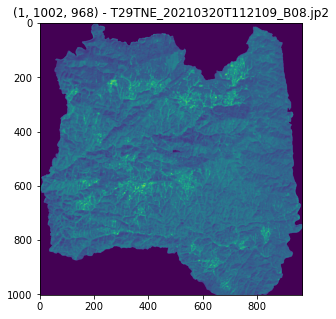

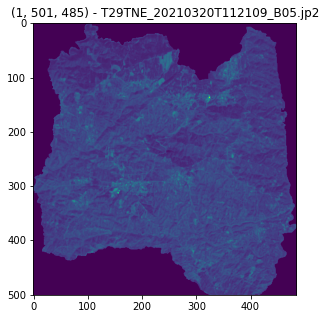

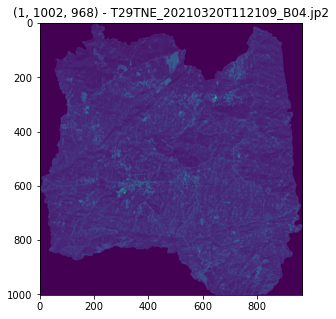

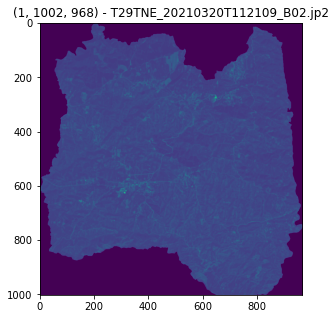

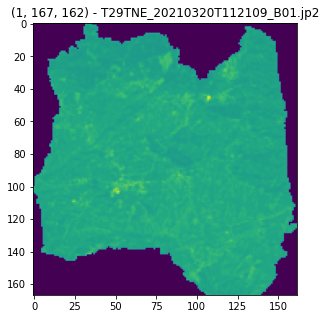

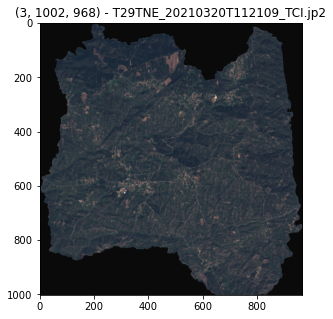

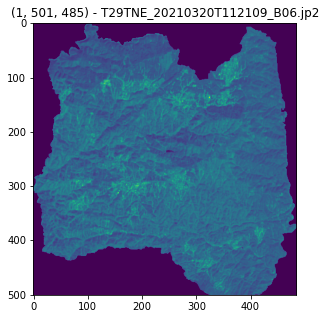

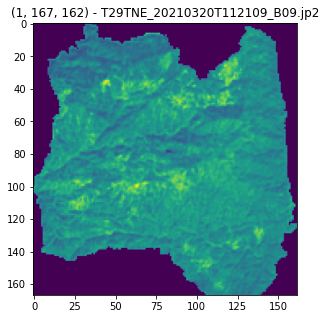

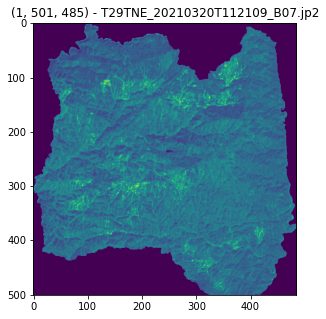

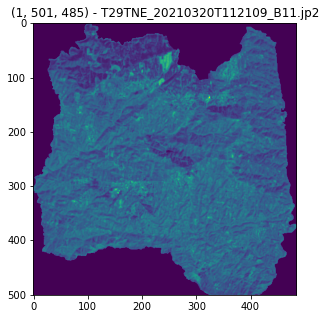

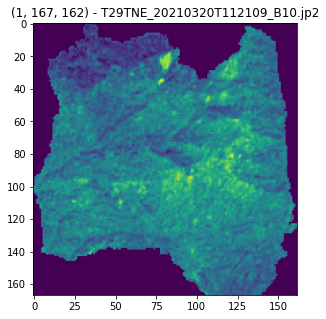

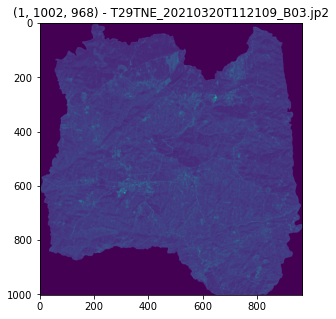

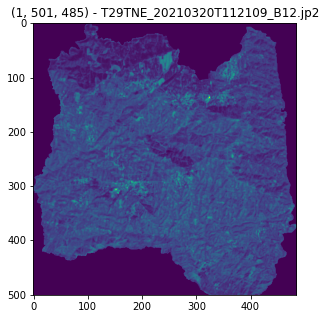

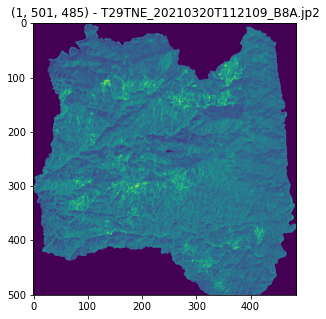

In [14]:
for i in os.listdir(image_dir):
    with rasterio.open(os.path.join(image_dir, i)) as src:
            out_image, out_transform = rasterio.mask.mask(src, transform_shapefile(cardigos_shp), crop=True, nodata=10, all_touched=True)
            out_meta = src.meta.copy() 
            plt.figure(figsize=(5,5))
            plt.title(f'{np.array(out_image).shape} - {i}')
            show(out_image)